1. Nettoyage
2. Analyse des variables
3. Encodage (OneHot, LabelEncoder...)
4. Normalisation (et centrage)
5. Split données
6. Fit sur X_train, y_train 
7. Score sur X_test, y_test

In [516]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [517]:
df = pd.read_csv('data/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Ajout de features

# Split des data

In [518]:
df.sex = df.sex.astype('category')
df.smoker = df.smoker.astype('category')
df.region = df.region.astype('category')

y = df['charges']
df = df.drop('charges', axis=1)
X = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.85)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', X_train.shape)
print('y_test', X_test.shape)

X_train (1137, 6)
X_test (201, 6)
y_train (1137, 6)
y_test (201, 6)


In [519]:
from sklearn import set_config
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import ElasticNetCV, LassoCV

from feature_engine.creation import MathFeatures
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from feature_engine.discretisation import ArbitraryDiscretiser
set_config(transform_output = "pandas")

alphas = np.linspace(.1, 50, 20)
l1_ratios = np.linspace(0.01, 1, 20)
bmi_dict = {'bmi': [0, 18.5, 25, 30, 40, np.Inf]}

transformers = [
    ('OHE', OneHotEncoder(variables=['region'])),
    ('smoker', OrdinalEncoder(variables=['smoker', 'sex'])),
    ('bmi_smoker', MathFeatures(['age', 'smoker'], func='prod')),
    ('kbins bmi', ArbitraryDiscretiser(binning_dict=bmi_dict, return_object=False, return_boundaries=True)),
    ('ohe bmi', OneHotEncoder(variables=['bmi'])),
    ('poly', PolynomialFeatures(interaction_only=False)),
    ('scaler', MinMaxScaler())
]

preprocessor = Pipeline(transformers)
preprocessor
df_preprocessor = preprocessor.fit_transform(X_train, y_train)
df_preprocessor.head()

/Users/maximekuil/Documents/Simplon/projet_assuraimant/.venv/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = y.groupby(X[var]).mean()  # type: ignore


,1,age,sex,children,smoker,region_northwest,region_southeast,region_southwest,region_northeast,prod_age_smoker,...,"bmi_(40.0, inf]^2","bmi_(40.0, inf] bmi_(18.5, 25.0]","bmi_(40.0, inf] bmi_(30.0, 40.0]","bmi_(40.0, inf] bmi_(-0.001, 18.5]","bmi_(18.5, 25.0]^2","bmi_(18.5, 25.0] bmi_(30.0, 40.0]","bmi_(18.5, 25.0] bmi_(-0.001, 18.5]","bmi_(30.0, 40.0]^2","bmi_(30.0, 40.0] bmi_(-0.001, 18.5]","bmi_(-0.001, 18.5]^2"
331,0.0,0.739130,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.812500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,0.0,0.260870,1.0,0.4,0.0,0.0,1.0,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1039,0.0,0.021739,1.0,0.4,0.0,1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261,0.0,0.043478,0.0,0.2,1.0,0.0,1.0,0.0,0.0,0.312500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,0.0,0.195652,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.421875,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [520]:
from sklearn.linear_model import LinearRegression

transformers.append(('lasso', LassoCV(alphas=alphas, fit_intercept=False, max_iter=1000000, cv=5)))
# transformers.append(('model', ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, fit_intercept=False, max_iter=100000)))

pipe = Pipeline(transformers)
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
predictions = pipe.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
print('Score :', score)
print('RMSE :', mse)
print('alpha :', pipe.named_steps.lasso.alpha_)
#print('l1 :', pipe.named_steps.model.l1_ratio_)

/Users/maximekuil/Documents/Simplon/projet_assuraimant/.venv/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = y.groupby(X[var]).mean()  # type: ignore


Score : 0.8917158922930022
RMSE : 4060.563420916398
alpha : 26.363157894736844


In [523]:
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.85)
df_preprocessor = preprocessor.fit_transform(X, y)

visualizer = ResidualsPlot(pipe.named_steps.lasso, X_train, y_train, X_test, y_test)

/Users/maximekuil/Documents/Simplon/projet_assuraimant/.venv/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = y.groupby(X[var]).mean()  # type: ignore


TypeError: unhashable type: 'Series'

# Cook distance

In [ ]:
np.set_printoptions(suppress=True)

#create instance of influence
influence = preprocessor.named_steps.lasso.get_influence()

#obtain Cook's distance for each observation
cooks = influence.cooks_distance

#display Cook's distances
print(cooks)

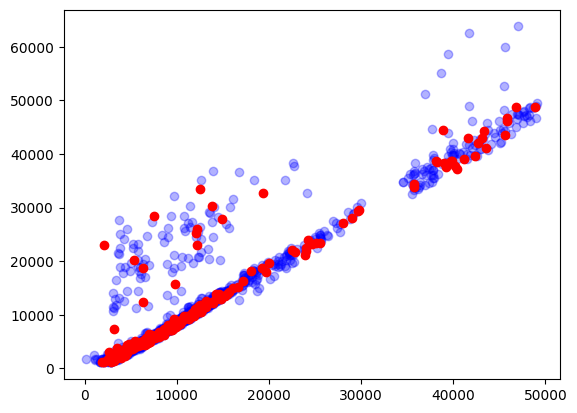

In [473]:
predictions_test = preprocessor.predict(X_test)
predictions_train = preprocessor.predict(X_train)

plt.scatter(predictions_train, y_train, color='blue', alpha=.3)
plt.scatter(predictions_test, y_test, color='red')

### Discrétisation de bmi pour la démo

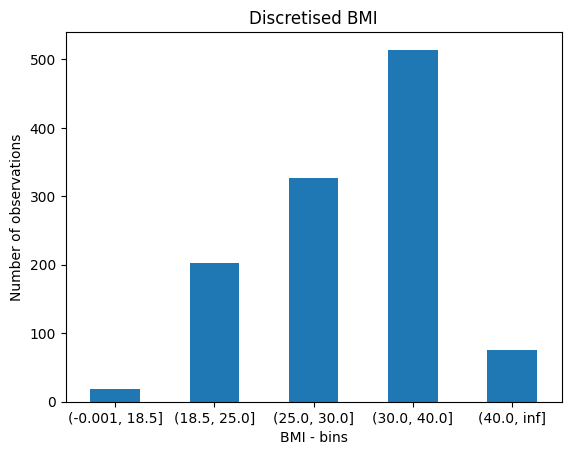

In [ ]:
from feature_engine.discretisation import ArbitraryDiscretiser

bmi_dict = {'bmi': [0, 18.5, 25, 30, 40, np.Inf]}
transformer = ArbitraryDiscretiser(binning_dict=bmi_dict, return_object=False, return_boundaries=True)

bmi = transformer.fit_transform(X_train)
bmi['bmi'].value_counts(ascending=True).sort_index().plot.bar(rot=0)
plt.xlabel('BMI - bins')
plt.ylabel('Number of observations')
plt.title('Discretised BMI')
plt.show()

### Sauvegarde du model

In [ ]:
import pickle
model_path = 'data/model.pickle'
save_comp = {
    'model': preprocessor
}
pickle.dump(save_comp, open(model_path, 'wb')) # Save model dans data

### chargement du model et prédiction

In [ ]:
m = pickle.load(open(model_path, 'rb'))
model = m['model']

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
print('Score :', score)
print('RMSE :', mse)

# test predict sur un individu

t = pd.DataFrame([['no', 'male', 18, 15.0, 0, 'northeast']], columns = ['smoker', 'sex', 'age', 'bmi', 'children', 'region'])
model.predict(t)


Score : 0.8901327360133643
RMSE : 4090.1392284991343


array([9976.42632004])

## Regression linéaire

In [ ]:
from sklearn.linear_model import LinearRegression

model = make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
print('Score :', score)
print('MSE :', mse)

plt.scatter(X_test.bmi, y_test)
plt.scatter(X_test.bmi, predictions , c='r', lw=3)

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'Pipeline(steps=[('OHE', OneHotEncoder(variables=['region'])),
                ('smoker', OrdinalEncoder(variables=['smoker', 'sex'])),
                ('bmi_smoker',
                 MathFeatures(func='prod', variables=['bmi', 'smoker'])),
                ('kbins bmi',
                 ArbitraryDiscretiser(binning_dict={'bmi': [0, 18.5, 25, 30, 40,
                                                            inf]},
                                      return_boundaries=True)),
                ('ohe bmi', OneHotEncoder(variables=['bmi'])),
                ('poly', PolynomialFeatures()), ('scaler', MinMaxScaler()),
                ('model',
                 LassoCV(alphas=array([ 0.1       ,  2.72631579,  5.35263158,  7.97894737, 10.60526316,
       13.23157895, 15.85789474, 18.48421053, 21.11052632, 23.73684211,
       26.36315789, 28.98947368, 31.61578947, 34.24210526, 36.86842105,
       39.49473684, 42.12105263, 44.74736842, 47.37368421, 50.        ]),
                         fit_intercept=False, max_iter=1000000))])' (type <class 'sklearn.pipeline.Pipeline'>) doesn't